In [15]:
import cv2
import numpy as np
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
from skimage import io, img_as_float
from numba import njit
from collections import deque
from io import BytesIO

In [16]:
# --- 2D DCT and IDCT Functions ---
def dct2(block):
    """Performs a 2D Discrete Cosine Transform."""
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    """Performs a 2D Inverse Discrete Cosine Transform."""
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

In [17]:
# ---- Bit packer (packs bits into bytes) ----
class BitPacker:
    def __init__(self, stream):
        self.s = stream
        self.acc = 0
        self.n = 0
        self.bitcount = 0  # track total bits

    def write_bit(self, b: int):
        self.acc = (self.acc << 1) | (1 if b else 0)
        self.n += 1
        self.bitcount += 1
        if self.n == 8:
            self.s.write(bytes([self.acc & 0xFF]))
            self.acc = 0
            self.n = 0

    def flush(self):
        if self.n:
            self.acc <<= (8 - self.n)
            self.s.write(bytes([self.acc & 0xFF]))
            self.acc = 0
            self.n = 0

# ---- Arithmetic coder (range-coder style, uses BitPacker) ----
class ArithmeticCoder:
    def __init__(self, output_stream):
        self.output_stream = output_stream
        self.low = 0
        self.high = 0xFFFFFFFF
        self.bits_to_follow = 0
        self.bp = BitPacker(self.output_stream)

    def start_encoding(self):
        self.low = 0
        self.high = 0xFFFFFFFF
        self.bits_to_follow = 0
        self.bp = BitPacker(self.output_stream)

    def _put_bit(self, bit):
        self.bp.write_bit(bit)
        while self.bits_to_follow > 0:
            self.bp.write_bit(1 - bit)
            self.bits_to_follow -= 1

    def encode_symbol(self, symbol, cumulative_frequencies):
        start_freq, end_freq, total_freq = cumulative_frequencies.get(symbol, (0, 0, 1))
        rng = (self.high - self.low + 1)
        self.high = self.low + (rng * end_freq // total_freq) - 1
        self.low  = self.low + (rng * start_freq // total_freq)

        while True:
            if (self.high ^ self.low) & 0x80000000 == 0:
                self._put_bit(self.low >> 31)
                self.low  = (self.low << 1) & 0xFFFFFFFF
                self.high = ((self.high << 1) | 1) & 0xFFFFFFFF
            elif (self.low & 0x40000000) and not (self.high & 0x40000000):
                self.bits_to_follow += 1
                self.low  = ((self.low << 1) ^ 0x80000000) & 0xFFFFFFFF
                self.high = (((self.high << 1) | 1) ^ 0x80000000) & 0xFFFFFFFF
            else:
                break

    def end_encoding(self):
        self.bits_to_follow += 1
        if self.low & 0x40000000:
            self._put_bit(1)
        else:
            self._put_bit(0)
        self.bp.flush()


In [18]:
class ContextModel:
    """
    Manages dynamic frequency counts for symbols within different contexts,
    based on the ADCTC paper's specific models for NOSB and Sign.
    """
    def __init__(self):
        self.nosb_context_frequencies = {}
        self.sign_context_frequencies = {}
        self.partition_context_frequencies = {} # New: Add a dictionary for partition codes
        self.max_nosb_symbol = 25

    def get_cumulative_frequencies(self, context_state, model_type):
        if model_type == 'nosb':
            if context_state not in self.nosb_context_frequencies:
                self.nosb_context_frequencies[context_state] = {i: 1 for i in range(self.max_nosb_symbol + 1)}
            frequencies = self.nosb_context_frequencies[context_state]
        elif model_type == 'sign':
            if context_state not in self.sign_context_frequencies:
                self.sign_context_frequencies[context_state] = {0: 1, 1: 1}
            frequencies = self.sign_context_frequencies[context_state]
        elif model_type == 'partition': # New: Handle partition model
            if context_state not in self.partition_context_frequencies:
                self.partition_context_frequencies[context_state] = {0: 1, 1: 1, 2:1} # Symbols: 0 (no split), 1 (H/V split), 2 (Quad split)
            frequencies = self.partition_context_frequencies[context_state]
        else:
            raise ValueError("Invalid model type")

        sorted_symbols = sorted(frequencies.keys())
        cumulative_freq = {}
        total = 0
        for s in sorted_symbols:
            count = frequencies[s]
            cumulative_freq[s] = (total, total + count, sum(frequencies.values()))
            total += count

        return cumulative_freq

    def update_model(self, context_state, symbol, model_type):
        if model_type == 'nosb':
            if context_state not in self.nosb_context_frequencies:
                self.get_cumulative_frequencies(context_state, 'nosb')
            if symbol not in self.nosb_context_frequencies[context_state]:
                self.nosb_context_frequencies[context_state][symbol] = 0
            self.nosb_context_frequencies[context_state][symbol] += 1
        elif model_type == 'sign':
            if context_state not in self.sign_context_frequencies:
                self.get_cumulative_frequencies(context_state, 'sign')
            if symbol not in self.sign_context_frequencies[context_state]:
                self.sign_context_frequencies[context_state][symbol] = 0
            self.sign_context_frequencies[context_state][symbol] += 1
        elif model_type == 'partition': # New: Handle partition model update
            if context_state not in self.partition_context_frequencies:
                self.get_cumulative_frequencies(context_state, 'partition')
            if symbol not in self.partition_context_frequencies[context_state]:
                self.partition_context_frequencies[context_state][symbol] = 0
            self.partition_context_frequencies[context_state][symbol] += 1

In [19]:
def nosb(val: int) -> int:
    return 0 if val == 0 else int(abs(int(val))).bit_length()

def compute_K(maxr1: int, maxr2: int, maxr3: int, km: int) -> int:
    # same rule set as paper
    if maxr2 == maxr1:
        return 1 if maxr3 <= maxr1 else 2
    else:
        if maxr2 < maxr1:
            return 3
        else:
            if maxr2 == maxr1 + 1:
                return 4 if km == 1 else 5
            else:
                return 6

def zigzag_indices(H: int, W: int):
    coords = []
    for s in range(H + W - 1):
        if s % 2 == 0:
            i = min(s, H - 1); j = s - i
            while i >= 0 and j < W:
                coords.append((i, j)); i -= 1; j += 1
        else:
            j = min(s, W - 1); i = s - j
            while j >= 0 and i < H:
                coords.append((i, j)); i += 1; j -= 1
    return coords

def sign_triplets(u, v):
    # (a,b,c) sets around (u,v) exactly as paper
    return ((u-1, v), (u, v-1), (u-1, v-1)), \
           ((u-2, v), (u-1, v-1), (u, v-2)), \
           ((u-1, v+1), (u-1, v-1), (u-2, v))

def k1_from_abc(a, b, c):
    if a == 0 or b == 0 or c == 0: return 2
    num_pos = int(a > 0) + int(b > 0) + int(c > 0)
    return 0 if num_pos in (1, 3) else 1

def k23_from_abc(a, b, c):
    if (a > 0 and b > 0 and c > 0) or (a < 0 and b > 0 and c < 0): return 0
    if (a < 0 and b < 0 and c < 0) or (a > 0 and b < 0 and c > 0): return 1
    return 2


In [20]:
import numpy as np
from io import BytesIO

# Assuming dct2, idct2, ContextModel, and ArithmeticCoder are defined elsewhere

class ADCTCCompressor:
    def __init__(self, min_block_size=8, max_block_size=64, QS=12):
        self.min_block_size = min_block_size
        self.max_block_size = max_block_size
        self.QS = QS
        self.Tr = 0.63 * QS
        self.coder = None
        self.context_model = ContextModel()

    def cost_function_E(self, block):
        dct_block = dct2(block)
        abs_coeff = np.abs(dct_block)
        E = np.sum(np.log(1 + abs_coeff / self.QS))
        return E

    def partition_optimization(self, block, r_offset=0, c_offset=0):
        h, w = block.shape
        if h <= self.min_block_size or w <= self.min_block_size:
            # leaf node
            return ('leaf', r_offset, c_offset, h, w), [(block, (r_offset, c_offset), h, w)]

        cost_no_split = self.cost_function_E(block)
        h2, w2 = h // 2, w // 2
        cost_h_split = self.cost_function_E(block[:h2, :]) + self.cost_function_E(block[h2:, :])
        cost_v_split = self.cost_function_E(block[:, :w2]) + self.cost_function_E(block[:, w2:])
        best = min(cost_no_split, cost_h_split, cost_v_split)

        if best == cost_no_split:
            return ('leaf', r_offset, c_offset, h, w), [(block, (r_offset, c_offset), h, w)]
        elif best == cost_h_split:
            left_tree,  left_blocks  = self.partition_optimization(block[:h2, :], r_offset,        c_offset)
            right_tree, right_blocks = self.partition_optimization(block[h2:, :], r_offset + h2,   c_offset)
            return ('H', left_tree, right_tree), (left_blocks + right_blocks)
        else:
            left_tree,  left_blocks  = self.partition_optimization(block[:, :w2], r_offset,        c_offset)
            right_tree, right_blocks = self.partition_optimization(block[:,  w2:], r_offset,        c_offset + w2)
            return ('V', left_tree, right_tree), (left_blocks + right_blocks)


    @staticmethod
    def zig_zag_scan(block):
        rows, cols = block.shape
        result = []
        row, col = 0, 0
        up = True
        for _ in range(rows * cols):
            result.append(block[row, col])
            if up:
                if col == cols - 1:
                    row += 1
                    up = False
                elif row == 0:
                    col += 1
                    up = False
                else:
                    row -= 1
                    col += 1
            else:
                if row == rows - 1:
                    col += 1
                    up = True
                elif col == 0:
                    row += 1
                    up = True
                else:
                    row += 1
                    col -= 1
        return result

    @staticmethod
    def get_2d_coords(index, rows, cols):
        row, col = 0, 0
        up = True
        for i in range(rows * cols):
            if i == index:
                return row, col
            if up:
                if col == cols - 1:
                    row += 1
                    up = False
                elif row == 0:
                    col += 1
                    up = False
                else:
                    row -= 1
                    col += 1
            else:
                if row == rows - 1:
                    col += 1
                    up = True
                elif col == 0:
                    row += 1
                    up = True
                else:
                    row += 1
                    col -= 1
        return row, col

    def compress(self, img):
        """
        ADCTC (encoder-side only):
          - Partition (forest) per tile and serialize PS as raw 2-bit codes (preorder).
          - For each leaf block: DCT -> threshold-before-quant (paper) -> quantize -> reconstruct from Q.
          - Entropy coding:
              * Arithmetic stream for r (NOSB) with context model_id = maxr1 + 25*K
              * RAW bitstream for LOW-bits of |Q| (drop MSB)
              * Arithmetic stream for sign with model_id = 9*k1 + 3*k2 + k3
        Returns:
          reconstructed_img (uint8), total_bits, CR, all_partition_blocks (for drawing)
        """
        import numpy as np
        from io import BytesIO

        h, w = img.shape
        # --- streams ---
        ps_stream = BytesIO()               # partition raw 2-bit codes
        arith_stream = BytesIO()            # arithmetic (r + sign)
        raw_stream = BytesIO()              # low-bits raw

        # packers / coder
        bp_ps = BitPacker(ps_stream)
        bp_raw = BitPacker(raw_stream)
        self.coder = ArithmeticCoder(arith_stream)
        self.coder.start_encoding()

        # --- tiny helper: serialize PS in preorder as raw 2-bit codes ---
        def ps_serialize_preorder(node):
            kind = node[0]
            if kind == 'leaf':
                bp_ps.write_bit(0); bp_ps.write_bit(0)
                return
            elif kind == 'H':
                bp_ps.write_bit(0); bp_ps.write_bit(1)
                ps_serialize_preorder(node[1])
                ps_serialize_preorder(node[2])
            elif kind == 'V':
                bp_ps.write_bit(1); bp_ps.write_bit(0)
                ps_serialize_preorder(node[1])
                ps_serialize_preorder(node[2])
            else:
                raise ValueError("Bad PS node")

        # --- pad to tile size ---
        pad_h = 0 if h % self.max_block_size == 0 else self.max_block_size - (h % self.max_block_size)
        pad_w = 0 if w % self.max_block_size == 0 else self.max_block_size - (w % self.max_block_size)
        padded_img = np.pad(img, ((0, pad_h), (0, pad_w)), mode='edge').astype(np.float64)
        H, W = padded_img.shape

        # --- partition per tile, serialize PS, collect leaves ---
        all_blocks = []   # list of (block, (r_off,c_off), bh, bw)
        for i in range(0, H, self.max_block_size):
            for j in range(0, W, self.max_block_size):
                tile = padded_img[i:i+self.max_block_size, j:j+self.max_block_size]
                tree, blocks = self.partition_optimization(tile, i, j)  # << باید نسخهٔ درختی باشه
                ps_serialize_preorder(tree)
                all_blocks.extend(blocks)

        # --- reconstruction target ---
        reconstructed_img = np.zeros((H, W), dtype=np.float64)

        # --- per-leaf processing ---
        for b, (r_off, c_off), bh, bw in all_blocks:
            X = dct2(b.astype(np.float64))
            zz = zigzag_indices(bh, bw)

            Q = np.zeros((bh, bw), dtype=np.int32)
            r_map = np.zeros((bh, bw), dtype=np.int32)

            # ----- pass 1: build Q with threshold-before-quant (paper), track r in 1D order
            prev_r = []
            for idx, (u, v) in enumerate(zz):
                Xi = X[u, v]
                # ring maxima from previous coded r's (1D coding order)
                def r_at(k): return prev_r[-k] if k <= len(prev_r) else 0
                maxr1, maxr2, maxr3 = r_at(1), r_at(2), r_at(3)
                km = 1 if (len(prev_r) >= 2 and maxr2 == (maxr1 + 1)) else 0
                K = compute_K(maxr1, maxr2, maxr3, km)

                # threshold rule BEFORE quantization (exactly as paper)
                if (maxr1 == 0) and (abs(Xi) < self.Tr) and (K != 6):
                    Qi = 0
                else:
                    Qi = int(np.round(Xi / float(self.QS)))

                Q[u, v] = Qi
                r = nosb(Qi)
                r_map[u, v] = r
                prev_r.append(r)

            # ----- reconstruct (pre-coding) from Q
            recon = idct2(Q.astype(np.float64) * float(self.QS))
            recon = np.clip(recon, 0.0, 255.0)
            reconstructed_img[r_off:r_off+bh, c_off:c_off+bw] = recon

            # ----- pass 2: entropy coding r, LOW-bits, sign (contexts exactly per paper)
            prev_r = []
            zz_index = {coord: k for k, coord in enumerate(zz)}

            for idx, (u, v) in enumerate(zz):
                r = int(r_map[u, v])

                # NOSB model id
                def r_at(k): return prev_r[-k] if k <= len(prev_r) else 0
                maxr1, maxr2, maxr3 = r_at(1), r_at(2), r_at(3)
                km = 1 if (len(prev_r) >= 2 and maxr2 == (maxr1 + 1)) else 0
                K = compute_K(maxr1, maxr2, maxr3, km)
                nosb_model_id = maxr1 + 25 * K

                # encode r (clamp to model alphabet)
                nosb_model = self.context_model.get_cumulative_frequencies(nosb_model_id, 'nosb')
                r_sym = min(max(r, 0), self.context_model.max_nosb_symbol)
                self.coder.encode_symbol(r_sym, nosb_model)
                self.context_model.update_model(nosb_model_id, r_sym, 'nosb')

                if r > 0:
                    q = int(Q[u, v])
                    mag = abs(q)
                    # LOW-bits (raw): drop MSB of |Q|
                    lowbits = bin(mag)[2:][1:]
                    for ch in lowbits:
                        bp_raw.write_bit(1 if ch == '1' else 0)

                    # sign context
                    def s_at(uu, vv):
                        # use only if neighbor exists AND earlier in zigzag
                        return int(np.sign(Q[uu, vv])) if ((uu, vv) in zz_index and zz_index[(uu, vv)] < idx) else 0
                    (a1, b1, c1), (a2, b2, c2), (a3, b3, c3) = sign_triplets(u, v)
                    s1 = k1_from_abc(s_at(*a1), s_at(*b1), s_at(*c1))
                    s2 = k23_from_abc(s_at(*a2), s_at(*b2), s_at(*c2))
                    s3 = k23_from_abc(s_at(*a3), s_at(*b3), s_at(*c3))
                    sign_model_id = 9 * s1 + 3 * s2 + s3

                    sign_model = self.context_model.get_cumulative_frequencies(sign_model_id, 'sign')
                    sign_bit = 0 if q >= 0 else 1   # 0:'+' , 1:'-'
                    self.coder.encode_symbol(sign_bit, sign_model)
                    self.context_model.update_model(sign_model_id, sign_bit, 'sign')

                prev_r.append(r)

        # --- finalize streams & stats ---
        self.coder.end_encoding()
        bp_ps.flush()
        bp_raw.flush()

        ps_bits = bp_ps.bitcount
        arith_bits = self.coder.bp.bitcount
        raw_bits = bp_raw.bitcount
        total_bits = ps_bits + arith_bits + raw_bits

        original_bits = h * w * 8
        cr = (original_bits / total_bits) if total_bits > 0 else float('inf')

        # crop padding and return
        reconstructed_img = reconstructed_img[:h, :w].astype(np.uint8)
        return reconstructed_img, total_bits, cr, all_blocks


In [21]:
def draw_partitions_on_image(image, partitions):
    if image.ndim == 2:
        img_with_partitions = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        img_with_partitions = image.copy()

    line_color = (0, 255, 0)
    for _, (r_off, c_off), bh, bw in partitions:
        cv2.rectangle(img_with_partitions, (c_off, r_off), (c_off + bw, r_off + bh), line_color, 1)
    return img_with_partitions


In [22]:
# ===== 1) ADCTC with fixed QS: outputs (rec_u8, CR, bits) =====
def compress_adctc_fixed_qs(img_u8: np.ndarray, QS: float, max_block_size: int = 64):
    comp = ADCTCCompressor(QS=QS, max_block_size=max_block_size)
    rec_u8, bits, cr, _ = comp.compress(img_u8)
    return rec_u8, cr, bits


# ===== 2) JPEG2000 with target CR: binary search on OpenCV parameter =====
def compress_jpeg2000_by_cr(img_float01: np.ndarray, target_cr: float,
                            k_lo: int = 1, k_hi: int = 900, iters: int = 12):
    """
    img_float01: float in [0,1]
    target_cr: target Compression Ratio
    returns: (rec_float01, cr_achieved, bits)
    """
    H, W = img_float01.shape
    orig_bits = H * W * 8.0
    target_bits = orig_bits / float(target_cr)
    img_u8 = (img_float01 * 255.0 + 0.5).astype(np.uint8)

    def enc_bits(k):
        ok, enc = cv2.imencode('.jp2', img_u8,
                               [cv2.IMWRITE_JPEG2000_COMPRESSION_X1000, int(k)])
        if not ok:
            return None, float('inf')
        bits = int(enc.size) * 8
        rec = cv2.imdecode(enc, 0).astype(np.float32) / 255.0
        return rec, bits

    # Initial guess
    cur = int(max(1, min(900, round(1000.0 / max(1e-6, target_cr)))))
    rec, bits = enc_bits(cur)
    if bits == float('inf'):
        cur = 250
        rec, bits = enc_bits(cur)

    best = (rec, abs(bits - target_bits), bits, cur)
    lo, hi = k_lo, k_hi
    for _ in range(iters):
        rec, bits = enc_bits(cur)
        if bits == float('inf'):
            break
        err = abs(bits - target_bits)
        if err < best[1]:
            best = (rec, err, bits, cur)
        # Empirical observation: larger k → more bits (higher quality)
        if bits > target_bits:
            hi = cur - 1
        else:
            lo = cur + 1
        if lo > hi:
            break
        cur = (lo + hi) // 2

    rec_best, _, bits_best, _ = best
    cr_ach = (orig_bits / bits_best) if bits_best > 0 else float('inf')
    return rec_best, cr_ach, bits_best


# ===== 3) Run comparison on list of QS =====
def compare_adctc_vs_j2k_by_qs(img_u8: np.ndarray, qs_list):
    img_f = img_u8.astype(np.float32) / 255.0
    CRs, QSs = [], []
    PSNR_adct, PSNR_j2k = [], []
    PHM_adct, PHM_j2k   = [], []
    FSIM_adct, FSIM_j2k = [], []

    for QS in qs_list:
        # ADCTC @ QS
        rec_adct_u8, crA, bitsA = compress_adctc_fixed_qs(img_u8, float(QS))
        rec_adct_f = rec_adct_u8.astype(np.float32)/255.0
        psnrA = cv2.PSNR(img_f, rec_adct_f, R=1.0)
        phmA  = psnr_hvs_m(img_u8, rec_adct_u8)
        fsA = fsim(img_u8, rec_adct_u8)      # 0..1

        # JPEG2000 @ matched CR
        rec_j2k_f, crJ, _ = compress_jpeg2000_by_cr(img_f, crA)
        rec_j2k_u8 = (np.clip(rec_j2k_f,0,1)*255.0+0.5).astype(np.uint8)
        psnrJ = cv2.PSNR(img_f, rec_j2k_f, R=1.0)
        phmJ  = psnr_hvs_m(img_u8, rec_j2k_u8)
        fsJ = fsim(img_u8, rec_j2k_u8)       # 0..1

        CRs.append(crA); QSs.append(QS)
        PSNR_adct.append(psnrA);  PSNR_j2k.append(psnrJ)
        PHM_adct.append(phmA);    PHM_j2k.append(phmJ)
        FSIM_adct.append(fsA);    FSIM_j2k.append(fsJ)

        print(f"QS={QS:>5} | ADCTC: CR={crA:6.2f}, PSNR={psnrA:5.2f}, PHM={phmA:5.2f}, FSIM={fsA:.4f} | "
              f"J2K: CR≈{crJ:6.2f}, PSNR={psnrJ:5.2f}, PHM={phmJ:5.2f}, FSIM={fsJ:.4f}")

    return {
        'QS': np.array(QSs, dtype=float),
        'CR': np.array(CRs, dtype=float),
        'PSNR_ADCT': np.array(PSNR_adct, dtype=float),
        'PSNR_J2K':  np.array(PSNR_j2k,  dtype=float),
        'PHM_ADCT':  np.array(PHM_adct,  dtype=float),
        'PHM_J2K':   np.array(PHM_j2k,   dtype=float),
        'FSIM_ADCT': np.array(FSIM_adct, dtype=float),
        'FSIM_J2K':  np.array(FSIM_j2k,  dtype=float),
    }


# ===== 4) Plot PSNR vs CR (with QS labels on ADCTC points) =====
def plot_psnr_vs_cr_from_qs(results):
    CR = results['CR']
    A = results['PSNR_ADCT']; J = results['PSNR_J2K']
    QS = results['QS']

    order = np.argsort(CR)
    CRs = CR[order]; A_ = A[order]; J_ = J[order]; QS_ = QS[order]

    plt.figure(figsize=(8,5))
    plt.plot(CRs, A_, marker='o', label='ADCTC')
    plt.plot(CRs, J_, marker='o', label='JPEG2000')
    # Label QS values on ADCTC points
    for x, y, q in zip(CRs, A_, QS_):
        plt.text(x, y, f"QS={int(q)}", fontsize=8, ha='left', va='bottom')
    plt.xlabel('Compression Ratio (achieved via ADCTC)')
    plt.ylabel('PSNR (dB)')
    plt.title('PSNR vs CR (CR taken from ADCTC; J2K matched)')
    plt.grid(True); plt.legend()
    plt.show()


In [23]:
# ---- PSNR-HVS-M (DCT 8x8 + CSF + masking) ----
_JPEG_Q = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]
], dtype=np.float64)

# CSF weights ~ inverse JPEG Q (normalized;
# DC is not forced to zero since in HVS-M it is handled by masking threshold)
_CSF = 1.0 / _JPEG_Q
_CSF /= _CSF.max()  # normalize to 1.0 at maximum

def _dct8(x):
    return dct(dct(x.T, norm='ortho').T, norm='ortho')

def psnr_hvs_m(ref_u8: np.ndarray, dist_u8: np.ndarray) -> float:
    """
    Approximate PSNR-HVS-M following Ponomarenko's approach:
      - 8x8 block DCT
      - CSF weighting (based on JPEG luma quantization matrix)
      - Visual masking:
          threshold T = k * (activity^alpha) * CSF
      - Error below threshold is clipped to 0, then squared and averaged

    Returns PSNR-HVS-M in dB.
    """
    ref = ref_u8.astype(np.float64)
    dst = dist_u8.astype(np.float64)
    H, W = ref.shape

    # pad to multiples of 8
    Hp = (H + 7) & ~7
    Wp = (W + 7) & ~7
    if (Hp, Wp) != (H, W):
        ref = np.pad(ref, ((0, Hp - H), (0, Wp - W)), mode='edge')
        dst = np.pad(dst, ((0, Hp - H), (0, Wp - W)), mode='edge')

    k_mask = 0.6   # masking strength (tuned as in common implementations)
    alpha  = 0.2   # masking non-linearity exponent
    mse_acc = 0.0
    ncoeff = 0

    for y in range(0, Hp, 8):
        for x in range(0, Wp, 8):
            a = _dct8(ref[y:y+8, x:x+8])
            b = _dct8(dst[y:y+8, x:x+8])
            d = a - b

            # Local activity estimation
            absA = np.abs(a)
            absB = np.abs(b)
            acA = absA.copy(); acB = absB.copy()
            acA[0,0] = 0.0; acB[0,0] = 0.0  # exclude DC from activity

            # CSF-weighted average activity
            actA = np.mean(acA * _CSF)
            actB = np.mean(acB * _CSF)
            activity = 0.5 * (actA + actB)

            # Masking threshold
            T = k_mask * (activity ** alpha) * _CSF
            T[0,0] = 0.0  # masking usually not applied on DC

            # Weighted error with CSF and masking
            Ew = np.abs(d) * _CSF
            Eeff = np.maximum(0.0, Ew - T)

            mse_acc += np.sum(Eeff * Eeff)
            ncoeff  += 64

    mse_hvs_m = mse_acc / float(ncoeff)
    if mse_hvs_m <= 0:
        return 100.0  # practically infinite
    return 10.0 * np.log10((255.0**2) / mse_hvs_m)

In [24]:
def plot_psnrhvs_vs_cr_from_qs(results):
    CR = results['CR']
    A = results['PHM_ADCT']; J = results['PHM_J2K']
    QS = results['QS']

    order = np.argsort(CR)
    CRs = CR[order]; A_ = A[order]; J_ = J[order]; QS_ = QS[order]

    plt.figure(figsize=(8,5))
    plt.plot(CRs, A_, marker='o', label='ADCTC')
    plt.plot(CRs, J_, marker='o', label='JPEG2000')
    for x, y, q in zip(CRs, A_, QS_):
        plt.text(x, y, f"QS={int(q)}", fontsize=8, ha='left', va='bottom')
    plt.xlabel('Compression Ratio (achieved via ADCTC)')
    plt.ylabel('PSNR-HVS-M (dB)')
    plt.title('PSNR-HVS-M vs CR (CR from ADCTC; J2K matched)')
    plt.grid(True); plt.legend()
    plt.show()


In [25]:
# ---------- FSIM (grayscale) ----------
def _gabor_even_odd_kernels(lmbd, theta, gamma=0.5, sigma=None):
    # If sigma not given, use a common default tied to wavelength
    if sigma is None:
        sigma = 0.56 * lmbd
    # Kernel size: odd, large enough to cover ~±3σ
    k = int(max(7, int(6*sigma+1)))
    if k % 2 == 0:
        k += 1
    # Even/odd (quadrature) Gabor pairs
    even = cv2.getGaborKernel((k, k), sigma, theta, lmbd, gamma, psi=0,            ktype=cv2.CV_32F)
    odd  = cv2.getGaborKernel((k, k), sigma, theta, lmbd, gamma, psi=np.pi/2,      ktype=cv2.CV_32F)
    return even, odd

def _pc_map(img_f01, scales=(4,8,16,32), n_orient=4):
    # img_f01: float32/64 in [0,1]
    # Phase congruency (proxy): accumulate local energy from quadrature Gabors
    pc_acc = np.zeros_like(img_f01, dtype=np.float32)
    for o in range(n_orient):
        theta = o * np.pi / n_orient
        for lmbd in scales:
            even, odd = _gabor_even_odd_kernels(lmbd, theta)
            re = cv2.filter2D(img_f01, cv2.CV_32F, even, borderType=cv2.BORDER_REFLECT)
            im = cv2.filter2D(img_f01, cv2.CV_32F, odd,  borderType=cv2.BORDER_REFLECT)
            amp = np.sqrt(re*re + im*im)  # local energy (quadrature pair)
            pc_acc += amp
    # Normalize to ~[0,1]
    pc_acc -= pc_acc.min()
    m = pc_acc.max()
    if m > 1e-12:
        pc_acc /= m
    return pc_acc  # ~[0,1]

def _gm_map(img_f01):
    # Gradient magnitude via Scharr (normalized to [0,1])
    gx = cv2.Scharr(img_f01, cv2.CV_32F, 1, 0) / 32.0
    gy = cv2.Scharr(img_f01, cv2.CV_32F, 0, 1) / 32.0
    gm = np.sqrt(gx*gx + gy*gy)
    m = gm.max()
    if m > 1e-12:
        gm /= m
    return gm  # [0,1]

def fsim(ref_u8: np.ndarray, dist_u8: np.ndarray) -> float:
    """
    Feature SIMilarity (FSIM) between ref and dist (both grayscale uint8).
    Returns the raw FSIM value in [0,1].
    (If you prefer a dB-style score, you could map with: -20*log10(1 - FSIM).)
    """
    ref = ref_u8.astype(np.float32) / 255.0
    dst = dist_u8.astype(np.float32) / 255.0

    PC1 = _pc_map(ref)
    PC2 = _pc_map(dst)
    GM1 = _gm_map(ref)
    GM2 = _gm_map(dst)

    # Stabilizers for similarity terms (typical values in [0,1] domain)
    T1 = 0.85     # for PC
    T2 = 0.0026   # for GM

    # Similarity maps for phase congruency and gradient magnitude
    S_pc = (2*PC1*PC2 + T1) / (PC1*PC1 + PC2*PC2 + T1 + 1e-12)
    S_gm = (2*GM1*GM2 + T2) / (GM1*GM1 + GM2*GM2 + T2 + 1e-12)

    # Saliency weighting with the max of phase congruency maps
    PCm = np.maximum(PC1, PC2)
    FSIM_map = S_pc * S_gm

    # Weighted spatial pooling
    num = np.sum(FSIM_map * PCm)
    den = np.sum(PCm) + 1e-12
    fsim_val = float(num / den)  # [0,1]
    return fsim_val


In [26]:
def plot_fsim_vs_cr_from_qs(results):
    CR = results['CR']
    A = results['FSIM_ADCT']; J = results['FSIM_J2K']
    QS = results['QS']

    order = np.argsort(CR)
    CRs = CR[order]; A_ = A[order]; J_ = J[order]; QS_ = QS[order]

    plt.figure(figsize=(8,5))
    plt.plot(CRs, A_, marker='o', label='ADCTC')
    plt.plot(CRs, J_, marker='o', label='JPEG2000')
    for x, y, q in zip(CRs, A_, QS_):
        plt.text(x, y, f"QS={int(q)}", fontsize=8, ha='left', va='bottom')
    plt.xlabel('Compression Ratio (achieved via ADCTC)')
    plt.ylabel('FSIM (dB)')
    plt.title('FSIM vs CR (CR from ADCTC; J2K matched)')
    plt.grid(True); plt.legend()
    plt.show()

In [27]:
def compress_jpeg2000(img, cr):
    """
    Compresses an image using JPEG2000 via OpenCV.
    :param img: Input image (float in 0-1).
    :param cr: Compression Ratio.
    :return: Reconstructed image (float in 0-1).
    """
    img_uint8 = (img * 255).astype(np.uint8)
    # Set JPEG2000 compression parameters: IMWRITE_JPEG2000_COMPRESSION_X1000
    # The value is "quality" related, where 1000/CR gives a rough inverse relation
    # to achieve the desired compression ratio.
    param = [int(cv2.IMWRITE_JPEG2000_COMPRESSION_X1000), int(1000 / cr)]
    _, enc = cv2.imencode('.jp2', img_uint8, param)
    return cv2.imdecode(enc, 0).astype(np.float32)/255.0

[ADCTC @ QS=12] CR=8.17 | Bits=256622 | PSNR=38.76 dB
[JPEG2000 @ CR≈8.17] PSNR=37.32 dB


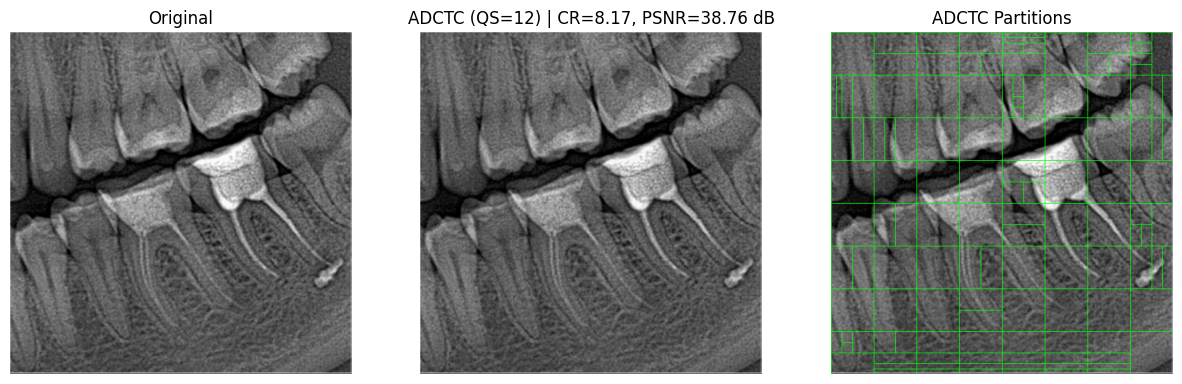

QS=    6 | ADCTC: CR=  4.45, PSNR=43.06, PHM=52.99, FSIM=0.9917 | J2K: CR≈  4.46, PSNR=41.22, PHM=49.16, FSIM=0.9867
QS=    8 | ADCTC: CR=  5.66, PSNR=41.15, PHM=50.56, FSIM=0.9861 | J2K: CR≈  5.68, PSNR=39.25, PHM=47.35, FSIM=0.9779
QS=   12 | ADCTC: CR=  8.17, PSNR=38.76, PHM=46.97, FSIM=0.9747 | J2K: CR≈  8.18, PSNR=37.32, PHM=45.18, FSIM=0.9666
QS=   16 | ADCTC: CR= 10.61, PSNR=37.28, PHM=44.50, FSIM=0.9640 | J2K: CR≈ 10.53, PSNR=36.12, PHM=43.53, FSIM=0.9570
QS=   20 | ADCTC: CR= 12.74, PSNR=36.20, PHM=42.66, FSIM=0.9547 | J2K: CR≈ 12.67, PSNR=35.29, PHM=41.76, FSIM=0.9467
QS=   24 | ADCTC: CR= 14.70, PSNR=35.30, PHM=41.14, FSIM=0.9450 | J2K: CR≈ 14.60, PSNR=34.68, PHM=40.79, FSIM=0.9390
QS=   28 | ADCTC: CR= 16.62, PSNR=34.51, PHM=39.88, FSIM=0.9374 | J2K: CR≈ 16.65, PSNR=33.98, PHM=39.52, FSIM=0.9331
QS=   32 | ADCTC: CR= 18.64, PSNR=33.79, PHM=38.77, FSIM=0.9306 | J2K: CR≈ 18.72, PSNR=33.30, PHM=38.37, FSIM=0.9221
QS=   36 | ADCTC: CR= 20.69, PSNR=33.16, PHM=37.82, FSIM=0.9236 

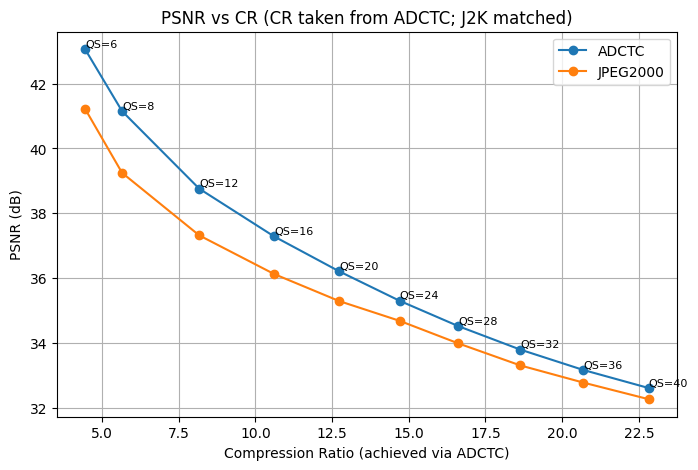

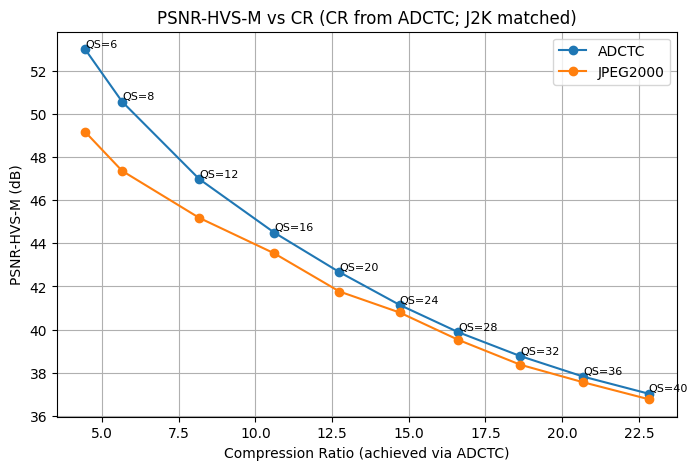

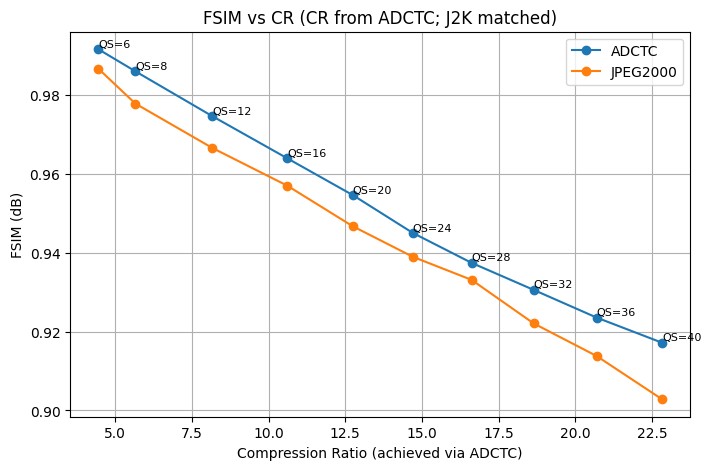

In [28]:
def main():
    """Demo ADCTC + fair JPEG2000 comparison (PSNR vs CR)"""

    # --- 1) Load image & to grayscale ---
    try:
        img_orig_color = io.imread("fig1_b.png")
        if img_orig_color.ndim == 3:
            # skimage gives RGB -> use RGB2GRAY (not BGR!)
            img_orig = cv2.cvtColor(img_orig_color, cv2.COLOR_RGB2GRAY)
        else:
            img_orig = img_orig_color
        img_orig = img_orig.astype(np.uint8)
    except FileNotFoundError:
        print("Image not found. Put 'fig1_b.png' next to this script.")
        return

    img_f = img_orig.astype(np.float32) / 255.0

    # --- 2) ADCTC @ QS=12 (show partitions & metrics) ---
    comp = ADCTCCompressor(QS=12, max_block_size=64)
    rec_adct_qs12_u8, bits_qs12, cr_qs12, parts = comp.compress(img_orig)
    psnr_adct_qs12 = cv2.PSNR(img_f, rec_adct_qs12_u8.astype(np.float32)/255.0, R=1.0)
    print(f"[ADCTC @ QS=12] CR={cr_qs12:.2f} | Bits={bits_qs12} | PSNR={psnr_adct_qs12:.2f} dB")

    # Optional: JPEG2000 matched to that CR (fair point compare)
    rec_j2k_qs12_f, cr_j2k_qs12, _ = compress_jpeg2000_by_cr(img_f, cr_qs12)
    psnr_j2k_qs12 = cv2.PSNR(img_f, rec_j2k_qs12_f, R=1.0)
    print(f"[JPEG2000 @ CR≈{cr_qs12:.2f}] PSNR={psnr_j2k_qs12:.2f} dB")

    # --- 3) Visualize original / ADCTC rec / partitions ---
    rec_with_boxes = draw_partitions_on_image(rec_adct_qs12_u8, parts)
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 3, 1); plt.imshow(img_orig, cmap='gray'); plt.title('Original'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.imshow(rec_adct_qs12_u8, cmap='gray')
    plt.title(f'ADCTC (QS=12) | CR={cr_qs12:.2f}, PSNR={psnr_adct_qs12:.2f} dB'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.imshow(cv2.cvtColor(rec_with_boxes, cv2.COLOR_BGR2RGB))
    plt.title('ADCTC Partitions'); plt.axis('off')
    plt.show()

    # --- 4) PSNR vs CR across QS list (ADCTC drives CR; J2K matches CR) ---
    qs_list = [6, 8, 12, 16, 20, 24, 28, 32, 36, 40]
    results = compare_adctc_vs_j2k_by_qs(img_orig, qs_list)
    plot_psnr_vs_cr_from_qs(results)       # PSNR
    plot_psnrhvs_vs_cr_from_qs(results)    # PSNR-HVS-M
    plot_fsim_vs_cr_from_qs(results)


    plt.show()

if __name__ == "__main__":
    main()